# G2++ Model Parameters Estimation Example

This notebook demonstrates how to calibrate the G2++ interest rate model using historical EURIBOR 3M data.

Since EURIBOR 3M is a forward rate it can be written as follow, derived from zero-coupon bond prices:

$$L(t; T, T+\delta) = \frac{1}{\delta} \left( \frac{P(t,T)}{P(t,T+\delta)} - 1 \right)$$

where $\delta = 0.25$ (3 months), and $P(t,T)$ is the zero-coupon bond price.

In the G2++ model, the ZC bond price is given by:

$$P(t, T) = A(t, T) \cdot \exp(-B_1(t,T) x_1(t) - B_2(t,T) x_2(t))$$

The calibration uses an **Extended Kalman Filter** to estimate the underlying short rate factors $(x_1, x_2)$ from observed EURIBOR rates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

module_path = os.path.abspath(os.getcwd())
if module_path not in sys.path:
    sys.path.append(module_path)

from ir_models.estimation.g2pp import G2ppKalmanMLE

Loading data from data/ERB3M_historic.xlsx...
Data filtered from 2021-09-01 to 2024-08-31.
Number of observations: 36


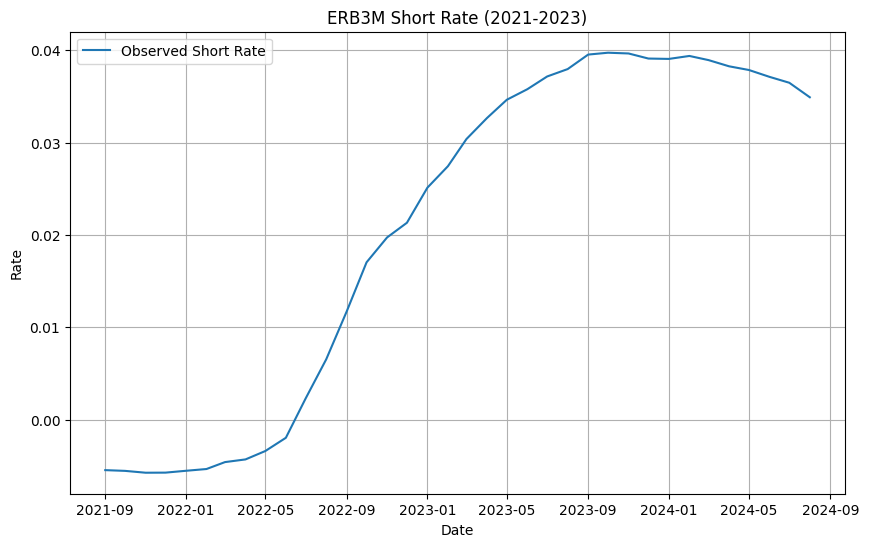

In [2]:
# Load data
file_path = 'data/ERB3M_historic.xlsx'
print(f"Loading data from {file_path}...")
df = pd.read_excel(file_path)

# Filter for 2021-2023 (3 years)
start_date = '2021-09-01'
end_date = '2024-08-31'

mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df_filtered = df.loc[mask].copy()

# Sort by date ascending (oldest first)
df_filtered = df_filtered.sort_values('Date', ascending=True)

print(f"Data filtered from {start_date} to {end_date}.")
print(f"Number of observations: {len(df_filtered)}")

# Extract rates (Dernier column) and convert to decimal
rates = df_filtered['Dernier'].values / 100.0
dates = df_filtered['Date'].values

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, label='Observed Short Rate')
plt.title('ERB3M Short Rate (2021-2023)')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
# Define phi function
# We set phi(t) = 0 as we don't have any term structure to fit, assuming no deterministic shift for this example.
def phi_func(t):
    return 0.0

dt = 1.0 / 12.0  # Monthly data

**Reminder:**

Two-factor Gaussian (G2++) dynamics for the zero-mean factors $x,y$ used in the code:

$\displaystyle dx_t = -a\,x_t\,dt + \sigma\,dW_t^{(1)},$

$\displaystyle dy_t = -b\,y_t\,dt + \eta\,dW_t^{(2)},$

with $\mathrm{corr}(dW^{(1)},dW^{(2)})=\rho$. The short rate is assembled as

$\displaystyle r_t = x_t + y_t + \phi(t)$,

where $\phi(t)$ is a deterministic shift (used to fit the observed term structure).

## Calibration Methodology

### EURIBOR as a function of Short Rate

EURIBOR 3M is not the instantaneous short rate $r(t)$. It is a **discrete forward rate** over a 3-month period:

$$L(t; T, T+\delta) = \frac{1}{\delta} \left( \frac{P(t,T)}{P(t,T+\delta)} - 1 \right)$$

where:
- $\delta = 0.25$ (3 months, 1/4 year)
- $P(t,T)$ is the zero-coupon bond price at time $t$ maturing at $T$

### G2++ Zero-Coupon Bond Formula

In the G2++ model:

$$P(t, T) = A(t, T) \cdot e^{-B_1(t,T) x_1(t) - B_2(t,T) x_2(t)}$$

with:

$$B_i(t,T) = \frac{1 - e^{-a_i (T-t)}}{a_i}$$

$$A(t,T) = \exp\left( \int_t^T \phi(s) ds - V(t,T) \right)$$

where $V(t,T)$ captures the variance contribution from the stochastic factors.

### Calibration via Extended Kalman Filter

Since the observation equation $L(t) = h(x_1(t), x_2(t))$ is **nonlinear**, we use an **Extended Kalman Filter (EKF)**:

1. **State transition** (linear): The factors evolve as Ornstein-Uhlenbeck processes
2. **Observation** (nonlinear): EURIBOR rate computed from ZC bond prices
3. **Linearization**: Compute Jacobian $H = \nabla h$ via finite differences at each step

In [4]:
# Initialize and run calibration
print("Parameter estimation of G2++ model from EURIBOR 3M observations...")

estimator = G2ppKalmanMLE(
    observations=rates,
    dt=dt,
    phi=phi_func,
    measurement_var=1e-6,
    observation_mode="euribor",      # EURIBOR mode: observe forward rates
    euribor_tenor=0.25,               # 3M = 0.25 years
    euribor_start_offset=0.0,         # Spot-starting EURIBOR
)

# Initial guess (only for parameters to be estimated)
initial_guess = {
#    "a": 0.01,
#    "b": 0.50,
    "sigma": 0.09,
    "eta": 0.09,
    "rho": -0.1,
    "measurement_var": 1e-5,
}

# Fix mean reversion parameters
fixed_params = {
    "a": 0.01,  # 1% mean reversion for first factor
    "b": 0.50,  # 50% mean reversion for second factor
}

result = estimator.fit(initial_guess=initial_guess, fixed_params=fixed_params)

print("\nEstimation Results:")
print(f"Optimisation success: {result.optimized}")
print(f"Log-likelihood: {result.log_likelihood:.4f}")
print("Estimated Parameters:")
for key, value in result.params.items():
    print(f"  {key}: {value:.6f}")

Parameter estimation of G2++ model from EURIBOR 3M observations...

Estimation Results:
Optimisation success: True
Log-likelihood: 172.4787
Estimated Parameters:
  sigma: 0.011972
  eta: 0.010821
  rho: -0.859542
  measurement_var: 0.000000
  a: 0.010000
  b: 0.500000


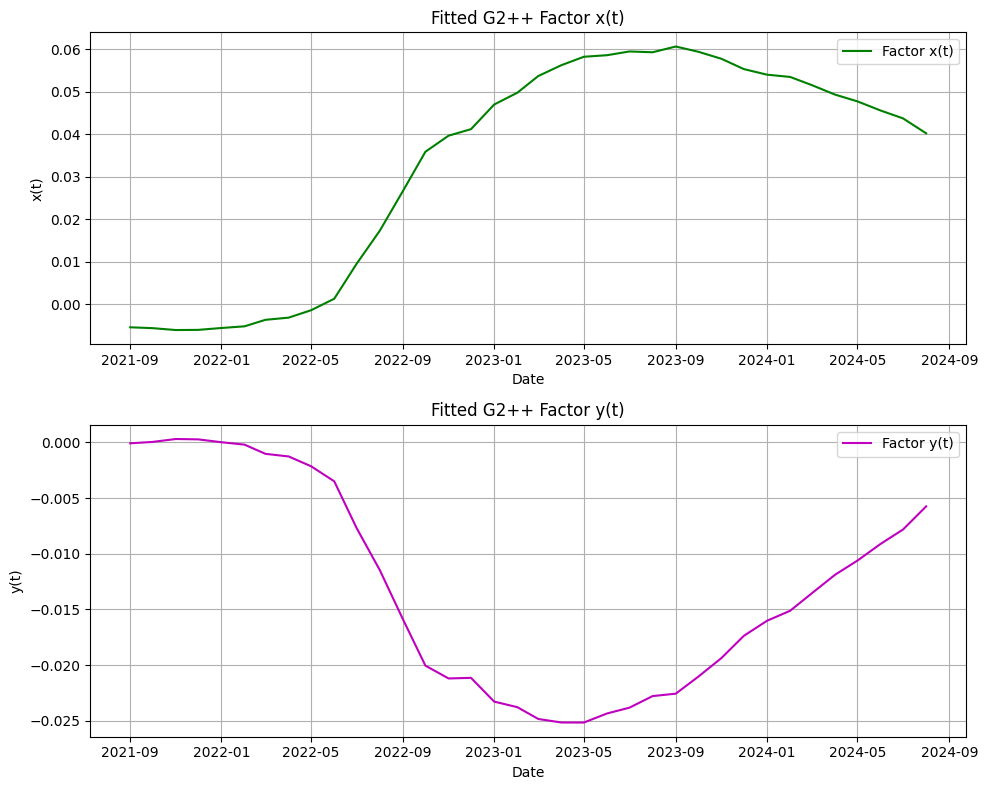

In [5]:
# Visualize the fitted factor states x(t) and y(t)
filtered_means = result.filtered_states
x_fitted = filtered_means[:, 0]
y_fitted = filtered_means[:, 1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot x factor
ax1.plot(dates, x_fitted, 'g-', label='Factor x(t)')
ax1.set_title('Fitted G2++ Factor x(t)')
ax1.set_xlabel('Date')
ax1.set_ylabel('x(t)')
ax1.grid(True)
ax1.legend()

# Plot y factor
ax2.plot(dates, y_fitted, 'm-', label='Factor y(t)')
ax2.set_title('Fitted G2++ Factor y(t)')
ax2.set_xlabel('Date')
ax2.set_ylabel('y(t)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

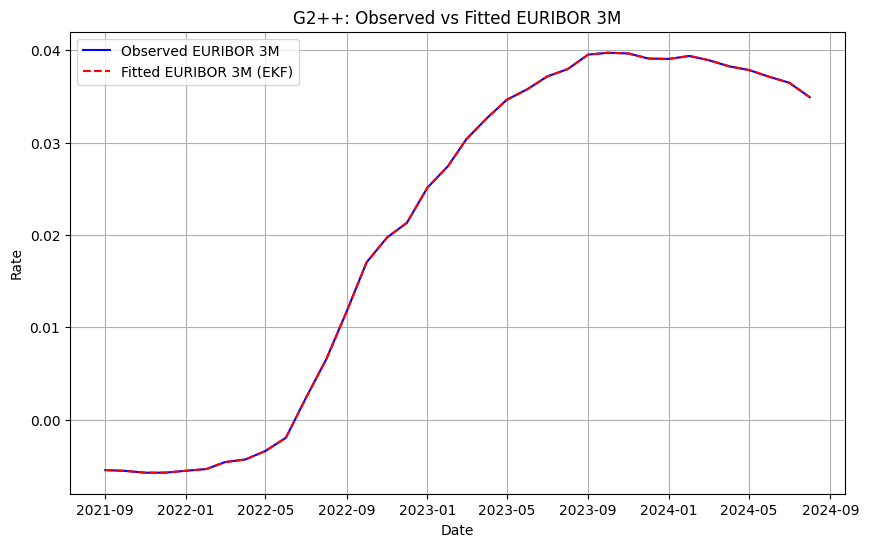


Fit Statistics:
Mean absolute error: 0.000004
Root mean squared error: 0.000005
Max absolute error: 0.000012


In [6]:
# Visualize fitted EURIBOR vs observed
# Reconstruct the fitted EURIBOR rate from the filtered factors

from ir_models.models.g2pp import G2ppZeroCouponPricing

# Create pricing object with estimated parameters
pricing = G2ppZeroCouponPricing(
    a=result.params["a"],
    b=result.params["b"],
    sigma=result.params["sigma"],
    eta=result.params["eta"],
    rho=result.params["rho"],
    phi=phi_func,
)

# Compute fitted EURIBOR rates from filtered states
fitted_euribor = []
for i in range(len(rates)):
    t = i * dt
    x1 = x_fitted[i]
    x2 = y_fitted[i]
    T_start = t + 0.0  # spot-starting
    euribor = pricing.euribor_rate(t, T_start, 0.25, x1, x2)
    fitted_euribor.append(euribor)

fitted_euribor = np.array(fitted_euribor)

plt.figure(figsize=(10, 6))
plt.plot(dates, rates, 'b-', label='Observed EURIBOR 3M', linewidth=1.5)
plt.plot(dates, fitted_euribor, 'r--', label='Fitted EURIBOR 3M (EKF)', linewidth=1.5)
plt.title('G2++: Observed vs Fitted EURIBOR 3M')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

# Compute residuals
residuals = rates - fitted_euribor
print(f"\nFit Statistics:")
print(f"Mean absolute error: {np.mean(np.abs(residuals)):.6f}")
print(f"Root mean squared error: {np.sqrt(np.mean(residuals**2)):.6f}")
print(f"Max absolute error: {np.max(np.abs(residuals)):.6f}")

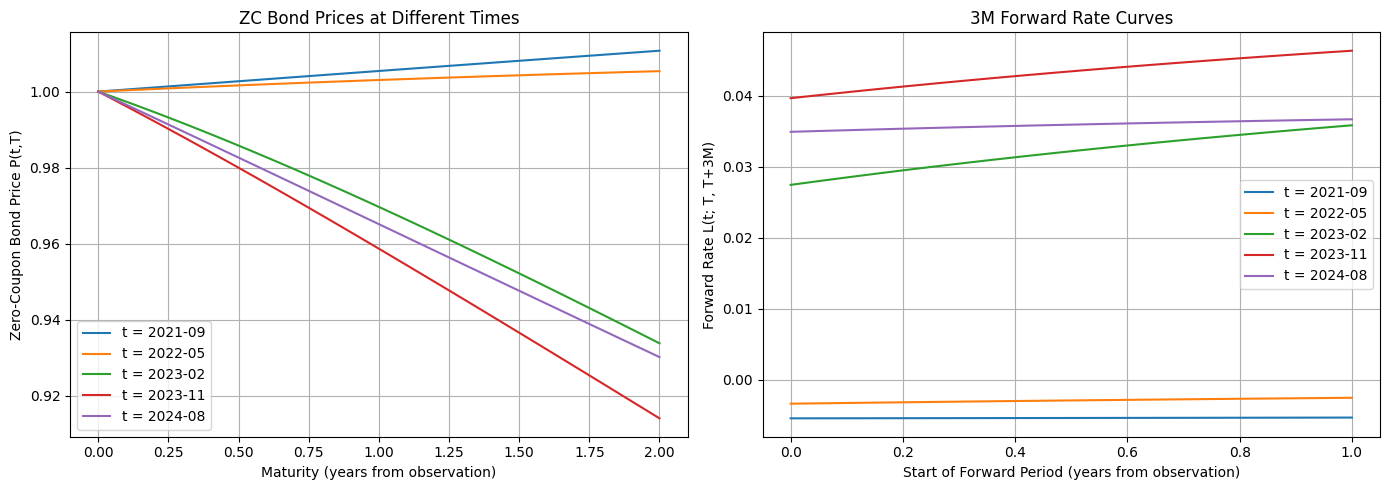

In [7]:
# Visualize zero-coupon bond prices at different observation times
# Let's show how P(t, T) and P(t, T+0.25) evolve

selected_indices = np.linspace(0, len(rates)-1, 5, dtype=int)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: ZC prices for selected dates
for idx in selected_indices:
    t = idx * dt
    x1 = x_fitted[idx]
    x2 = y_fitted[idx]
    
    maturities = np.linspace(t, t + 2.0, 50)  # 2-year horizon
    zc_prices = [pricing.zero_coupon_price(t, T, x1, x2) for T in maturities]
    
    date_str = pd.Timestamp(dates[idx]).strftime('%Y-%m')
    ax1.plot(maturities - t, zc_prices, label=f't = {date_str}')

ax1.set_xlabel('Maturity (years from observation)')
ax1.set_ylabel('Zero-Coupon Bond Price P(t,T)')
ax1.set_title('ZC Bond Prices at Different Times')
ax1.legend()
ax1.grid(True)

# Right panel: Implied forward rates
for idx in selected_indices:
    t = idx * dt
    x1 = x_fitted[idx]
    x2 = y_fitted[idx]
    
    tenors = np.linspace(0.0, 1.0, 20)  # Up to 1 year forward
    forward_rates = [pricing.euribor_rate(t, t + T_offset, 0.25, x1, x2) for T_offset in tenors]
    
    date_str = pd.Timestamp(dates[idx]).strftime('%Y-%m')
    ax2.plot(tenors, forward_rates, label=f't = {date_str}')

ax2.set_xlabel('Start of Forward Period (years from observation)')
ax2.set_ylabel('Forward Rate L(t; T, T+3M)')
ax2.set_title('3M Forward Rate Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()